# Exploation_06

## 1. Lyrics_model

### 1.1 모듈 설정

- import할 라이브러리를 보기 편하게 모아놓습니다.

In [ ]:
import os, re 
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense

- 이번에도 구글 드라이브를 활용합니다.

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


### 1.2 함수 정리

#### 1.2.1 preprocess_sentence

- 문장을 정규표현식으로 처리해줍니다.

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자 변환
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 기호 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백이 많을 수 있으면 하나로 통일
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # ""안에 들어간 기호들 외 공백 처리
    sentence = sentence.strip() # 위에서 생성한 양쪽 공백을 지워줍니다.
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작과 끝에 <start>와 <end>를 넣어줍니다.
    return sentence

- 위에 주석으로 처리했지만, 소문자, 특수문자, 공백을 정리하고 문장 앞과 끝에 'start', 'end'를 붙여주는 함수입니다.

#### 1.2.2 tokenize

- 단어장을 생성하고, 토큰화까지 진행합니다.

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )

    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)   

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    # 1차 시도에서는 maxlen=15로 설정하였습니다.
    # 2차 시도부터 sentence processing 단계에서 <statt>, <end> 포함 26개로 제한하였기에 지워줍니다.  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

- 단어장은 20,000개의 단어가 들어갈 수 있게 설정했고, 포함되지 못한 단어는 'unk'로 들어갑니다.
- 단어장 생성하고 바로 단어를 넣어줍니다. 그다음 text_to_sequences로 시퀀스화 시켜줍니다.
- 마지막으로 sequence.pad_sequences으로 padding작업을 진행합니다. 
- **첫번째 Adam optimizer를 사용한 모델에서는 maxlen 옵션을 15로 설정했습니다.**  
**tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)**
- **이후에는 sentence processing에서 start,end 포함 26자로 제한해서 넣기에 maxlen을 생략했습니다.**

#### 1.2.3 generate_text

- 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다.

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

#### 1.2.4 TextGenerator

- TextGenerator 클래스를 생성해 모델 layer를 쌓아줍니다.

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

- 일단은 embedding layer로 embedding을 진행합니다. 다음 순환신경망의 LSTM layer를 쌓고, 마지막 Dense층을 놓습니다.
- 텐서의 공식문서를 통해 추가할 수 있는 layer는 따로 추가해 보는 것도 좋겠습니다.

### 1.3 데이터

#### 1.3.1 데이터 로드

- google drive에서 lyrics 파일을 불러옵니다.

In [ ]:
txt_file_path = "/gdrive/My Drive/Colab Notebooks/data/lyrics/*"
txt_list = glob.glob(txt_file_path)

- 약 50여명의 가수의 가사를 모은 txt형태의 파일입니다.

#### 1.3.2 데이터 처리

1) 데이터 저장

- 불러온 파일을 raw_corpus 안에 문장 단위로 저장합니다.

In [ ]:
raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))

데이터 크기: 187088


- 데이터가 적지 않습니다...

- 불러온 데이터를 5줄 정도만 살펴보겠습니다.

In [ ]:
raw_corpus[:5]

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say"]

- 명곡의 가사들입니다.

2) 정규표현식

- 의미 없는 공백들은 삭제하고, 위에서 만든 preprosess_sentence를 이용해 정규표현식을 적용합니다.

In [ ]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
print(len(corpus))

175749


- 5줄을 불러와 raw_corpus와 비교합니다.

In [ ]:
corpus[:5]

['<start> yesterday , all my troubles seemed so far away <end>',
 '<start> now it looks as though they re here to stay <end>',
 '<start> oh , i believe in yesterday suddenly , i m not half the man i used to be <end>',
 '<start> there s a shadow hanging over me . <end>',
 '<start> oh , yesterday came suddenly why she had to go i don t know she wouldn t say <end>']

3) tokenize

- tokenize를 사용하여 padding까지 완료합니다.

In [ ]:
tensor, tokenizer = tokenize(corpus)

[[  2 873   4 ...   0   0   0]
 [  2  50  11 ...   0   0   0]
 [  2  39   4 ...   0   0   0]
 ...
 [  2  33  32 ...   0   0   0]
 [  2   5  34 ...   0   0   0]
 [  2  17  16 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fafb04c6810>


4) 데이터 정리

- 혹시나 배열이 길어 문장이 요약될 수 있으므로 생략없이 나올 수 있게 설정합니다.

In [ ]:
np.set_printoptions(threshold=np.inf)

- 분리 전에 살펴봅니다.

In [ ]:
print(tensor[:5])

[[   2  873    4   24   13 2584 2061   30  353  137    3    0    0    0    0]
 [   2   50   11  796   81  329   45   54   93   10  222    3    0    0    0]
 [  14  873 2431    4    5   22   70  541    6   82    5  291   10   27    3]
 [   2   65   16    9 2109 1100  146   12   20    3    0    0    0    0    0]
 [2431  112   48  116   10   53    5   37   15   34   48  674   15   68    3]]


- 'start'를 잘라 타겟을 만들고 배열을 같게 만들기 위해 맨 뒤 문장을 잘라버립니다.

In [ ]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[:5])
print(tgt_input[:5])

[[   2  873    4   24   13 2584 2061   30  353  137    3    0    0    0]
 [   2   50   11  796   81  329   45   54   93   10  222    3    0    0]
 [  14  873 2431    4    5   22   70  541    6   82    5  291   10   27]
 [   2   65   16    9 2109 1100  146   12   20    3    0    0    0    0]
 [2431  112   48  116   10   53    5   37   15   34   48  674   15   68]]
[[ 873    4   24   13 2584 2061   30  353  137    3    0    0    0    0]
 [  50   11  796   81  329   45   54   93   10  222    3    0    0    0]
 [ 873 2431    4    5   22   70  541    6   82    5  291   10   27    3]
 [  65   16    9 2109 1100  146   12   20    3    0    0    0    0    0]
 [ 112   48  116   10   53    5   37   15   34   48  674   15   68    3]]


5) 데이터 분리

- 결과를 확인했으니 데이터를 분리합니다.

In [ ]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=22)

- 데이터셋 객체를 생성합니다.

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

- vocab size는 단어장에 pad까지 해서 +1을 해줍니다.

### 1.4 모델

#### 1.4.1 모델 생성

- embedding_size는 128을 주고, hidden_size는 2048을 줍니다.  
(계속 같은 조건으로 돌릴 예정이므로 size는 미리 지정합니다.)

In [ ]:
embedding_size = 128
hidden_size = 2048

1) Adam optimizer

- 위에서 만든 TextGenerator를 이용하고, optimizer는 Adam을 사용해보겠습니다. 

In [ ]:
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
# pad가 들어갔으므로 +1을 해주고 위에서 지정한 embedding_size와 hidden_size를 넣어줍니다.

history = []

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

- dataset, val_data를 넣고 모델 학습을 합니다. 

In [ ]:
history = model.fit(dataset, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
686/686 [==============================] - 418s 589ms/step - loss: 3.8841 - val_loss: 3.4738
Epoch 2/10
686/686 [==============================] - 414s 604ms/step - loss: 3.3488 - val_loss: 3.2127
Epoch 3/10
686/686 [==============================] - 429s 625ms/step - loss: 3.1467 - val_loss: 3.0202
Epoch 4/10
686/686 [==============================] - 412s 600ms/step - loss: 2.9641 - val_loss: 2.8301
Epoch 5/10
686/686 [==============================] - 417s 607ms/step - loss: 2.7950 - val_loss: 2.6608
Epoch 6/10
686/686 [==============================] - 417s 607ms/step - loss: 2.6361 - val_loss: 2.4959
Epoch 7/10
686/686 [==============================] - 417s 608ms/step - loss: 2.4813 - val_loss: 2.3376
Epoch 8/10
686/686 [==============================] - 417s 608ms/step - loss: 2.3316 - val_loss: 2.1868
Epoch 9/10
686/686 [==============================] - 417s 608ms/step - loss: 2.1884 - val_loss: 2.0406
Epoch 10/10
686/686 [==============================] - 417s 608m

- val_loss를 더 줄일 방법을 고민해보겠습니다.
- 그 전에 위에서 만든 generate_text를 이용해 가사를 뽑아봅니다.

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=15)

'<start> i love you , liberian girl <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i hate", max_len=15)

'<start> i hate the way you shake your mind <end> '

- 가사가 나쁘지 않습니다.

2) Loss 줄이기

- Garbage in, garbage out  
loss 를 줄이기 위해 고민했는데, 원인은 데이터 같습니다.  
- 노래 가사에도 분명 의미없는 후렴구 반복도 있으니, 문장 처리하는 과정부터 다시 살펴봅니다. 

In [ ]:
print(len(corpus[0].split()))
print(corpus[0])
print(len(corpus[1].split()))
print(corpus[1])
print(len(corpus[2].split()))
print(corpus[2])
print(len(corpus))

length = [len(tokens.split()) for tokens in corpus]
# print(length)

11
<start> yesterday , all my troubles seemed so far away <end>
12
<start> now it looks as though they re here to stay <end>
20
<start> oh , i believe in yesterday suddenly , i m not half the man i used to be <end>
175749


- 띄어쓰기 단위로 구분하여 너무 긴 가사는 제외하려합니다.

In [ ]:
    print("min : ", np.min(length))
    print("max : ", np.max(length))
    print("mean : ", np.mean(length))
    print("std : ", np.std(length))

min :  2
max :  347
mean :  10.52070282049969
std :  4.809910973545654


- 평균은 10 정도네요

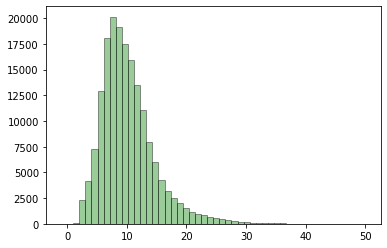

In [ ]:
plt.hist(length, color = 'green', alpha = 0.4, bins = 50, range = [-1, 50],edgecolor = 'black')
plt.show()

- 50까지만 보겠습니다.
- 너무 과하게 자르기보다는 저는 27단어 수준에서 자르는게 좋다고 판단했습니다(start, end 포함)

In [ ]:
length_w = [i for i, value in enumerate(length) if value >= 26]
print(len(length_w))
# print(length_w)

1953


- print(length_w)로 인덱스를 불러온 후 확인했습니다.
- 데이터가 너무 길어 주석처리하고 다시 실행합니다.

In [ ]:
print(corpus[181])
print(corpus[821])
print(corpus[3481])
print(len(length_w))

<start> ah love , love , love , love , love , love , love , love , love . there s nothing you can do that can t be done . <end>
<start> i don t know why you say goodbye , i say hello . hello , goodbye , hello , goodbye . hello , goodbye . hello , goodbye . <end>
<start> like impressionist pictures , or wagner s rugged music , the very absence of conventional form challenges attention . in emily dickinson s exacting hands , the especial , intrinsic fitness of a particular order of words might not be sacrificed to anything virtually extrinsic and her verses all show a strange cadence of inner rhythmical music . lines are always daringly constructed , and the thought rhyme appears frequently , appealing , indeed , to an unrecognized sense more elusive than hearing . <end>
1953


- 심각합니다. 특히 3481번은 음악에 대한 설명이 들어간 것 같습니다.

- corpus에 넣기 전 과정으로 다시 돌아가서 띄어쓰기로 카운팅 했을 때 25가 넘어가면 제외하고 preprocess_sentence를 합니다.

In [ ]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence.count(" ") >= 25: continue
    corpus.append(preprocessed_sentence)
        

print(len(corpus))

173796


- 원래 총 175,749 문장이었는데 1,953개를 제외하고 173,796 문장을 담아줍니다.

In [ ]:
tensor, tokenizer = tokenize(corpus)

[[  2 878   4 ...   0   0   0]
 [  2  50  11 ...   0   0   0]
 [  2  41   4 ...   0   0   0]
 ...
 [  2  36  32 ...   0   0   0]
 [  2   5  33 ...   0   0   0]
 [  2  17  16 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fafbf538a10>


- 사전에 미리 문장을 제한하여 담아서 tokenize 과정에서도 0, 3(end)로 잘 padding될 것입니다.

- 다시 이전 과정을 반복합니다.

In [ ]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2  878    4   25   13 2578 2040   30  356  135    3    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[ 878    4   25   13 2578 2040   30  356  135    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=22)

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 24), dtype=tf.int32, name=None), TensorSpec(shape=(256, 24), dtype=tf.int32, name=None))>

- 모두 완료했으니 다음 스텝으로 넘어갑니다.

### 1.5 Optimizer

- Optimizer를 따로 기술하는 이유는 oprimizer에 따른 변화가 궁금해서입니다.  
keras에서 제공하는 optimizer를 다 이용해보겠습니다.

- **maxlen 제한을 제거했습니다.**  
(이유는 sentence processing 과정에서 단어를 제한해서 받았기 때문입니다.)

- embedding의 input_dim, output_dim, epoch 등은 다 동일합니다  
(optimizer만 변경하며 결과를 보겠습니다)

- model과 histroy의 이름 앞에 '(optimizer_name)_'을 넣어 구분했습니다.

#### 1.5.1 Adam_optimizer

- 첫번째로 시도하는 Adam optimizer는 바로 직전에 돌린 optimizer와 동일합니다.

In [ ]:
Adam_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Adam_history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Adam_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Adam_history = Adam_model.fit(dataset,
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
678/678 [==============================] - 723s 1s/step - loss: 2.2464 - val_loss: 1.9805
Epoch 2/10
678/678 [==============================] - 725s 1s/step - loss: 1.9433 - val_loss: 1.8197
Epoch 3/10
678/678 [==============================] - 726s 1s/step - loss: 1.7872 - val_loss: 1.6833
Epoch 4/10
678/678 [==============================] - 727s 1s/step - loss: 1.6661 - val_loss: 1.5683
Epoch 5/10
678/678 [==============================] - 728s 1s/step - loss: 1.5581 - val_loss: 1.4613
Epoch 6/10
678/678 [==============================] - 727s 1s/step - loss: 1.4605 - val_loss: 1.3681
Epoch 7/10
678/678 [==============================] - 728s 1s/step - loss: 1.3715 - val_loss: 1.2828
Epoch 8/10
678/678 [==============================] - 728s 1s/step - loss: 1.2885 - val_loss: 1.1988
Epoch 9/10
678/678 [==============================] - 727s 1s/step - loss: 1.2101 - val_loss: 1.1244
Epoch 10/10
678/678 [==============================] - 729s 1s/step - loss: 1.1357 - val_lo

- 기대 이상입니다, val_loss도 잘 떨어지는 것을 확인할 수 있습니다.

In [ ]:
generate_text(Adam_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you , liberian girl <end> '

In [ ]:
generate_text(Adam_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate my love <end> '

- liberian girl만 찾네요... 마이클잭슨 영향을 많이 받은 것 같습니다.

#### 1.5.2 Adagrad_optimizer

In [ ]:
Adagrad_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Adagrad_history = []
epochs = 10

optimizer = tf.keras.optimizers.Adagrad()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Adagrad_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Adagrad_history = Adagrad_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 732s 1s/step - loss: 2.6353 - val_loss: 2.3207
Epoch 2/10
678/678 [==============================] - 717s 1s/step - loss: 2.3076 - val_loss: 2.2712
Epoch 3/10
678/678 [==============================] - 718s 1s/step - loss: 2.2619 - val_loss: 2.2317
Epoch 4/10
678/678 [==============================] - 717s 1s/step - loss: 2.2244 - val_loss: 2.1994
Epoch 5/10
678/678 [==============================] - 717s 1s/step - loss: 2.1978 - val_loss: 2.1785
Epoch 6/10
678/678 [==============================] - 718s 1s/step - loss: 2.1805 - val_loss: 2.1639
Epoch 7/10
678/678 [==============================] - 719s 1s/step - loss: 2.1677 - val_loss: 2.1526
Epoch 8/10
678/678 [==============================] - 718s 1s/step - loss: 2.1572 - val_loss: 2.1429
Epoch 9/10
678/678 [==============================] - 717s 1s/step - loss: 2.1483 - val_loss: 2.1347
Epoch 10/10
678/678 [==============================] - 718s 1s/step - loss: 2.1400 - val_lo

In [ ]:
generate_text(Adagrad_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you be you be <end> '

In [ ]:
generate_text(Adagrad_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate you be you be <end> '

- optimizer가 잘 안 맞나봅니다. loss 값도 뽑아낸 문장도 맘에 안 듭니다.

#### 1.5.3 Adadelta_optimizer

In [ ]:
Adadelta_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Adadelta_history = []
epochs = 10

optimizer = tf.keras.optimizers.Adadelta()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Adadelta_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Adadelta_history = Adadelta_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 732s 1s/step - loss: 4.1709 - val_loss: 2.9569
Epoch 2/10
678/678 [==============================] - 718s 1s/step - loss: 2.8608 - val_loss: 2.7546
Epoch 3/10
678/678 [==============================] - 721s 1s/step - loss: 2.6766 - val_loss: 2.5803
Epoch 4/10
678/678 [==============================] - 718s 1s/step - loss: 2.5221 - val_loss: 2.4613
Epoch 5/10
678/678 [==============================] - 715s 1s/step - loss: 2.4309 - val_loss: 2.3922
Epoch 6/10
678/678 [==============================] - 719s 1s/step - loss: 2.3776 - val_loss: 2.3526
Epoch 7/10
678/678 [==============================] - 720s 1s/step - loss: 2.3480 - val_loss: 2.3317
Epoch 8/10
678/678 [==============================] - 719s 1s/step - loss: 2.3327 - val_loss: 2.3205
Epoch 9/10
678/678 [==============================] - 718s 1s/step - loss: 2.3240 - val_loss: 2.3137
Epoch 10/10
678/678 [==============================] - 706s 1s/step - loss: 2.3183 - val_lo

In [ ]:
generate_text(Adadelta_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love , <end> '

In [ ]:
generate_text(Adadelta_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate , <end> '

- Adadelta도 Adagrad와 마찬가지입니다... 넘어갑니다.

#### 1.5.4 Adamax_optimizer

In [ ]:
Adamax_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Adamax_history = []
epochs = 10

optimizer = tf.keras.optimizers.Adamax()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Adamax_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Adamax_history = Adamax_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 708s 1s/step - loss: 2.5187 - val_loss: 2.2206
Epoch 2/10
678/678 [==============================] - 699s 1s/step - loss: 2.1333 - val_loss: 2.0606
Epoch 3/10
678/678 [==============================] - 704s 1s/step - loss: 2.0332 - val_loss: 1.9735
Epoch 4/10
678/678 [==============================] - 708s 1s/step - loss: 1.9535 - val_loss: 1.9004
Epoch 5/10
678/678 [==============================] - 710s 1s/step - loss: 1.8864 - val_loss: 1.8363
Epoch 6/10
678/678 [==============================] - 710s 1s/step - loss: 1.8258 - val_loss: 1.7776
Epoch 7/10
678/678 [==============================] - 710s 1s/step - loss: 1.7679 - val_loss: 1.7190
Epoch 8/10
678/678 [==============================] - 711s 1s/step - loss: 1.7127 - val_loss: 1.6635
Epoch 9/10
678/678 [==============================] - 710s 1s/step - loss: 1.6575 - val_loss: 1.6079
Epoch 10/10
678/678 [==============================] - 710s 1s/step - loss: 1.6019 - val_lo

In [ ]:
generate_text(Adamax_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you so much <end> '

In [ ]:
generate_text(Adamax_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate you <end> '

- 깔끔하네요. loss 값도 준수하고, 문장도 군더더기 없이 딱 할 말만 뽑습니다.

#### 1.5.5 Nadam_optimizer

In [ ]:
Nadam_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Nadam_history = []
epochs = 10

optimizer = tf.keras.optimizers.Nadam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Nadam_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Nadam_history = Nadam_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 728s 1s/step - loss: 2.6282 - val_loss: 2.2252
Epoch 2/10
678/678 [==============================] - 733s 1s/step - loss: 2.0686 - val_loss: 1.8699
Epoch 3/10
678/678 [==============================] - 736s 1s/step - loss: 1.8106 - val_loss: 1.6626
Epoch 4/10
678/678 [==============================] - 736s 1s/step - loss: 1.6318 - val_loss: 1.4807
Epoch 5/10
678/678 [==============================] - 736s 1s/step - loss: 1.4669 - val_loss: 1.3221
Epoch 6/10
678/678 [==============================] - 737s 1s/step - loss: 1.3188 - val_loss: 1.1799
Epoch 7/10
678/678 [==============================] - 736s 1s/step - loss: 1.1861 - val_loss: 1.0564
Epoch 8/10
678/678 [==============================] - 736s 1s/step - loss: 1.0685 - val_loss: 0.9503
Epoch 9/10
678/678 [==============================] - 737s 1s/step - loss: 0.9665 - val_loss: 0.8614
Epoch 10/10
678/678 [==============================] - 737s 1s/step - loss: 0.8807 - val_lo

In [ ]:
generate_text(Nadam_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you so much , i love you so much , i love you so much <end> '

In [ ]:
generate_text(Nadam_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate the headlines and the weather <end> '

- 매우 훌륭합니다. loss값이 매우 낮고, 문장도 나름 가사 같습니다. i hate으로 뽑은 문장이 독특합니다.

#### 1.5.6 RMSprop_optimizer

In [ ]:
RMSprop_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

RMSprop_history = []
epochs = 10

optimizer = tf.keras.optimizers.RMSprop()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

RMSprop_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
RMSprop_history = RMSprop_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 722s 1s/step - loss: 2.2525 - val_loss: 1.8977
Epoch 2/10
678/678 [==============================] - 720s 1s/step - loss: 1.8367 - val_loss: 1.6749
Epoch 3/10
678/678 [==============================] - 719s 1s/step - loss: 1.6462 - val_loss: 1.4715
Epoch 4/10
678/678 [==============================] - 719s 1s/step - loss: 1.4769 - val_loss: 1.2962
Epoch 5/10
678/678 [==============================] - 720s 1s/step - loss: 1.3201 - val_loss: 1.1349
Epoch 6/10
678/678 [==============================] - 722s 1s/step - loss: 1.1821 - val_loss: 1.0150
Epoch 7/10
678/678 [==============================] - 723s 1s/step - loss: 1.0698 - val_loss: 0.9157
Epoch 8/10
678/678 [==============================] - 726s 1s/step - loss: 0.9813 - val_loss: 0.8471
Epoch 9/10
678/678 [==============================] - 724s 1s/step - loss: 0.9149 - val_loss: 0.7969
Epoch 10/10
678/678 [==============================] - 728s 1s/step - loss: 0.8676 - val_lo

In [ ]:
generate_text(RMSprop_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you so much , i love you so much , i love you so much <end> '

In [ ]:
generate_text(RMSprop_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate to see her go <end> '

- 너무 맘에드는 결과입니다. 특히 저는 이 문장이 좋습니다.

#### 1.5.7 Ftrl_optimizer

In [ ]:
Ftrl_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

Ftrl_history = []
epochs = 10

optimizer = tf.keras.optimizers.Ftrl()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

Ftrl_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
Ftrl_history = Ftrl_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 354s 494ms/step - loss: 2.6376 - val_loss: 2.3082
Epoch 2/10
678/678 [==============================] - 334s 492ms/step - loss: 2.2832 - val_loss: 2.2419
Epoch 3/10
678/678 [==============================] - 334s 492ms/step - loss: 2.2439 - val_loss: 2.2097
Epoch 4/10
678/678 [==============================] - 334s 492ms/step - loss: 2.2130 - val_loss: 2.1899
Epoch 5/10
678/678 [==============================] - 334s 492ms/step - loss: 2.1916 - val_loss: 2.1750
Epoch 6/10
678/678 [==============================] - 334s 492ms/step - loss: 2.1784 - val_loss: 2.1637
Epoch 7/10
678/678 [==============================] - 334s 493ms/step - loss: 2.1688 - val_loss: 2.1556
Epoch 8/10
678/678 [==============================] - 334s 492ms/step - loss: 2.1616 - val_loss: 2.1491
Epoch 9/10
678/678 [==============================] - 334s 492ms/step - loss: 2.1554 - val_loss: 2.1432
Epoch 10/10
678/678 [==============================] - 334s 493m

In [ ]:
generate_text(Ftrl_model, tokenizer, init_sentence="<start> i love", max_len=27)

'<start> i love you be the the <end> '

In [ ]:
generate_text(Ftrl_model, tokenizer, init_sentence="<start> i hate", max_len=27)

'<start> i hate you be you be <end> '

- Adagrad_optimizer와 매우 유사합니다. 뽑아내는 문장까지 비슷하네요.

#### 1.5.8 SGD_optimizer

In [ ]:
SGD_model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

SGD_history = []
epochs = 10

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

SGD_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
SGD_history = SGD_model.fit(dataset, 
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(enc_val, dec_val),
                   verbose=1)

Epoch 1/10
678/678 [==============================] - 341s 483ms/step - loss: 1625.8226 - val_loss: 1407.5691
Epoch 2/10
678/678 [==============================] - 327s 482ms/step - loss: 1449.0771 - val_loss: 1322.9907
Epoch 3/10
678/678 [==============================] - 327s 482ms/step - loss: 1559.8180 - val_loss: 1213.4432
Epoch 4/10
678/678 [==============================] - 327s 482ms/step - loss: 1336.6394 - val_loss: 1420.5491
Epoch 5/10
 56/678 [=>............................] - ETA: 4:39 - loss: 1364.7087

KeyboardInterrupt: ignored

In [ ]:
generate_text(SGD_model, tokenizer, init_sentence="<start> i love", max_len=27)

In [ ]:
generate_text(SGD_model, tokenizer, init_sentence="<start> i hate", max_len=27)

- 327s 482ms/step - loss: 1336.6394 - val_loss: 1420.5491
- 그만 알아봅니다...

### 1.6 정리

In [ ]:
plt.plot(history.history['loss'])
plt.plot(Adam_history.history['loss'])
plt.plot(Adagrad_history.history['loss'])
plt.plot(Adadelta_history.history['loss'])
plt.plot(Adamax_history.history['loss'])
plt.plot(Nadam_history.history['loss'])
plt.plot(RMSprop_history.history['loss'])
plt.plot(Ftrl_history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original', 'Adam', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam', 'RMSprop', 'Ftrl'], loc='upper left')
plt.show()

NameError: ignored

- 시각화는 포기해야겠습니다. 도중에 런타임이 끊겨서 다시 시작했는데 기존에 학습한 history가 사라졌습니다. 

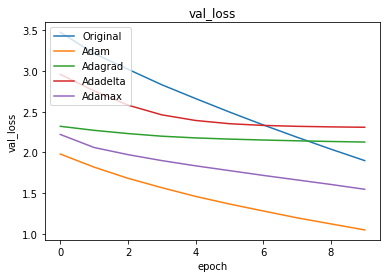

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(Adam_history.history['val_loss'])
plt.plot(Adagrad_history.history['val_loss'])
plt.plot(Adadelta_history.history['val_loss'])
plt.plot(Adamax_history.history['val_loss'])
plt.title('val_loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Original', 'Adam', 'Adagrad', 'Adadelta', 'Adamax'], loc='upper left')
plt.show()

- 이건 중간에 시도한 history의 val_loss를 시각화 한 것 입니다.
- 지금은 이 자료도 다 삭제되었지만 재실행을 안해서 그래프 결과물만 남아있습니다.

## 2. 회고

1) dataset.api의 효용
 - 일단 dataset을 쓰면 속도가 빨라진다고 알고 있지만, 이번 경우에는 데이터가 크지 않아 별 효과가 없는 것 같습니다.
 - 여기서는 따로 집어넣지 않았는데 실험적으로 한 번 사용했으며,  그냥 train, val data를 나눈 상태에서 학습했습니다.  
 어짜피 train_test_split에서 shuffle=True 옵션은 줬으니까요.
 - 나중에 데이터가 더 많아지면 다시 비교해보겠습니다.
 - 그전에 학습한 내용을 토대로 추가할만한 옵션을 기록으로 남겨둡니다.  
 dataset = dataset.batch() => 배치 생성  
 dataset = dataset.cache() => preprosessing 시간을 줄이고 싶을 때  
 dataset = dataset.shuffle() => 데이터 셔플링  
 dataset = dataset.prefetch() => 데이터 로드시간을 줄이기 위해 미리 메모리에 적재시킴

2) maxlen의 필요성
 - maxlen으로 제한을 거는 것은 비효율적으로 생각됩니다.  
분명 3('end')이나 padding 결과인 0으로 끝나는 문장이 아닌 다른 단어로 잘린 문장도 그냥 들어갈 것 같습니다. 

3) Optimizer의 활용
 - optimizer 하나로도 차이가 크기 때문에 적절한 optimizer의 활용이 중요할 것 같습니다.  
 이런 형식의 시퀀스에서는 Nadam, Adam, RMSprop을 optimizer을 사용하고,  
 다른 프로젝트에서도 시간만 허락한다면 optimizer를 바꾸면서 확인하는 게 좋겠습니다.
 - 참고로 PyTorch에는 AdamW, RAdam, SparseAdam, ASGD(Averaged SGD), LBFGS, Rprop 등 keras에는 없는 것들이 있습니다...

4) 전처리의 필요성
 - 2번과 같은 의미에서 가사가 아닌 곡해석이 들어간 부분을 지적하고 싶습니다.  
  전처리는 필수라는 생각이 듭니다.   'Garbage in, garbage out'

5) colab 런타임
 - 거의 마지막에 다와서 런타임을 다시 시작했는데, 이게 기존의 자료를 날려먹었습니다(런타임 삭제 누른거 아닙니다)
 - 조심해야겠습니다.


## 3. References

- 아래의 사이트에서 많은 도움을 받았습니다.

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://dbstndi6316.tistory.com/297
- https://ebbnflow.tistory.com/135
- https://wikidocs.net/83544